***Лабораторная работа №4 "Написание LSTM модели". Коршунов Егор Станиславович БВТ2202***

**Цель:**
1. Написать LSTM модель, способную классифицировать текст на токсичный или не токсичный. 
2. В качестве токенизатора можно использовать любой токенизатор с hf либо написать свой эмбеддинг слой.
3. Использование в качестве лосса BCE. 
4. Использование в качестве оптимизатор Adam/AdamW, lr=3e-4. 
5. Рассчитать такие метрики, как: accuracy, f1, roc-auc, pr-auc.

In [9]:
# Импорт библиотек
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.auto import tqdm
import time
from tqdm import tqdm

In [10]:
# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Загрузка и анализ данных

Количество образцов: 14412
Соотношение токсичных комментариев: 0.33
Недостающие значения:
comment    0
toxic      0
dtype: int64


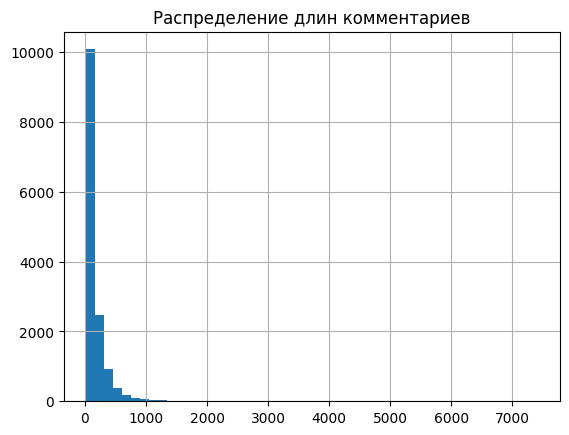

In [11]:
# Загрузка данных
df = pd.read_csv('labeled.csv', sep=',', on_bad_lines='skip')

# Переименование столбцов для удобства
df.columns = ['comment', 'toxic']

# Анализ данных
print(f"Количество образцов: {len(df)}")
print(f"Соотношение токсичных комментариев: {df['toxic'].mean():.2f}")
print(f"Недостающие значения:\n{df.isnull().sum()}")

# Удаление пропущенных значений
df = df.dropna()

# Гистограмма длины комментариев
df['comment_length'] = df['comment'].apply(len)
df['comment_length'].hist(bins=50)
plt.title('Распределение длин комментариев')
plt.show()

# Ограничение максимальной длины комментария
MAX_LENGTH = 256

Подготовка токенизатора

In [12]:
# Загрузка предобученного токенизатора BERT для русского языка
tokenizer = BertTokenizer.from_pretrained('ai-forever/ruBert-base')

Создание Dataset и DataLoader

In [13]:
# Кастомный класс датасета для обработки текстовых данных и их токенизации
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length): # Инициализация датасета
        self.texts = texts  # Список текстовых комментариев
        self.labels = labels  # Соответствующие метки (токсичный/нет)
        self.tokenizer = tokenizer  # Токенизатор BERT
        self.max_length = max_length  # Максимальная длина последовательности
    
    def __len__(self):
        # Возвращает общее количество примеров в датасете
        return len(self.texts)
    
    def __getitem__(self, idx): # Получение одного элемента датасета по индексу
        text = str(self.texts[idx])  # Получаем текст и приводим к строке
        label = self.labels[idx]  # Получаем соответствующую метку
        
        # Токенизация текста с помощью BERT-токенизатора
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Добавляем [CLS] и [SEP]
            max_length=self.max_length,  # Ограничиваем длину последовательности
            padding='max_length',  # Дополняем последовательность до max_length
            truncation=True,  # Обрезаем последовательность, если она длиннее max_length
            return_attention_mask=True,  # Возвращаем маску внимания
            return_tensors='pt',  # Возвращаем тензоры PyTorch
        )
        
        # Возвращаем словарь с токенизированными данными
        return {
            'input_ids': encoding['input_ids'].flatten(),  # ID токенов (выравниваем тензор)
            'attention_mask': encoding['attention_mask'].flatten(),  # Маска внимания
            'label': torch.tensor(label, dtype=torch.long)  # Метка в виде тензора
        }

# Разделение данных на обучающую, валидационную и тестовую выборки
# Первое разделение: 70% train, 30% временная (temp)
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42,  # Фиксируем random_state для воспроизводимости
    stratify=df['toxic']  # Сохраняем распределение классов
)

# Второе разделение: 50% от temp -> val и test (15% от исходных данных каждый)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['toxic']
)

# Создание объектов датасета для каждой выборки
train_dataset = ToxicCommentsDataset(
    train_df['comment'].values,  # Тексты для обучения
    train_df['toxic'].values,  # Метки для обучения
    tokenizer,  # Токенизатор
    MAX_LENGTH  # Максимальная длина последовательности
)

val_dataset = ToxicCommentsDataset(
    val_df['comment'].values,  # Тексты для валидации
    val_df['toxic'].values,  # Метки для валидации
    tokenizer,
    MAX_LENGTH
)

test_dataset = ToxicCommentsDataset(
    test_df['comment'].values,  # Тексты для тестирования
    test_df['toxic'].values,  # Метки для тестирования
    tokenizer,
    MAX_LENGTH
)

# Создание DataLoader'ов для эффективной загрузки данных
BATCH_SIZE = 16  # Размер батча

# DataLoader для обучающей выборки
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True  # Перемешиваем данные для обучения
)

# DataLoader для валидационной выборки (без перемешивания)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE
)

# DataLoader для тестовой выборки (без перемешивания)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

Модель BERT для классификации

In [14]:
# Класс для классификации токсичности на основе BERT
class BertForToxicClassification(nn.Module):
    def __init__(self, bert_model_name='ai-forever/ruBert-base', num_classes=1, dropout=0.1):
        super(BertForToxicClassification, self).__init__()
        
        # Визуализация загрузки BERT модели
        print(f"\n{'='*50}")
        print(f"Загрузка предобученной модели BERT: {bert_model_name}")
        print(f"{'='*50}")
        
        # Прогресс-бар для загрузки модели
        with tqdm(total=4, desc="Инициализация модели") as pbar:
            # 1. Загрузка конфигурации
            time.sleep(0.5)
            pbar.set_postfix_str("Загрузка конфигурации...")
            pbar.update(1)
            
            # 2. Загрузка весов модели
            time.sleep(1)
            pbar.set_postfix_str("Загрузка весов модели...")
            self.bert = BertModel.from_pretrained(bert_model_name)
            pbar.update(1)
            
            # 3. Инициализация dropout
            time.sleep(0.3)
            pbar.set_postfix_str("Инициализация Dropout...")
            self.dropout = nn.Dropout(dropout)
            pbar.update(1)
            
            # 4. Инициализация классификатора
            time.sleep(0.2)
            pbar.set_postfix_str("Создание классификатора...")
            self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
            pbar.update(1)
        
        print("\nМодель успешно загружена!")
        print(f"Архитектура:\n"
              f"- BERT слои: {len(self.bert.encoder.layer)}\n"
              f"- Размер скрытого слоя: {self.bert.config.hidden_size}\n"
              f"- Dropout: {dropout}\n"
              f"- Выходной слой: {num_classes} нейронов")
    
    def forward(self, input_ids, attention_mask):
        # Прямой проход через BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Получаем выход [CLS] токена
        pooled_output = outputs.pooler_output
        
        # Применяем dropout
        pooled_output = self.dropout(pooled_output)
        
        # Классификатор
        logits = self.classifier(pooled_output)
        
        return logits

# Визуализация создания модели
print("\nИнициализация модели классификации...")
start_time = time.time()

model = BertForToxicClassification().to(device)

print(f"\nМодель создана за {time.time() - start_time:.2f} секунд")
print(f"Модель перемещена на устройство: {device}")


Инициализация модели классификации...

Загрузка предобученной модели BERT: ai-forever/ruBert-base


Инициализация модели: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, Создание классификатора...]



Модель успешно загружена!
Архитектура:
- BERT слои: 12
- Размер скрытого слоя: 768
- Dropout: 0.1
- Выходной слой: 1 нейронов

Модель создана за 3.78 секунд
Модель перемещена на устройство: cuda


Функции для обучения и оценки

In [15]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, epoch_pbar=None):
    """Функция для выполнения одной эпохи обучения модели.
    
    Args:
        model: Модель для обучения
        data_loader: DataLoader с обучающими данными
        loss_fn: Функция потерь
        optimizer: Оптимизатор
        device: Устройство (CPU/GPU)
        scheduler: Опциональный планировщик скорости обучения
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        loss = loss_fn(outputs.view(-1), labels.float())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        # Обновление прогресс-бара
        if epoch_pbar is not None:
            epoch_pbar.update(1)
            epoch_pbar.set_postfix({
                'loss': f"{total_loss/(batch_idx+1):.4f}",
                'acc': f"{accuracy_score(all_labels, np.array(all_preds) > 0.5):.4f}"
            })
    
    # Вычисление метрик
    avg_loss = total_loss / len(data_loader)
    all_preds = np.array(all_preds) > 0.5
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    pr_auc = average_precision_score(all_labels, all_preds)
    
    return avg_loss, accuracy, f1, roc_auc, pr_auc

def eval_model(model, data_loader, loss_fn, device):
    """Функция для оценки модели на валидационном/тестовом наборе.
    
    Args:
        model: Модель для оценки
        data_loader: DataLoader с данными для оценки
        loss_fn: Функция потерь
        device: Устройство (CPU/GPU)
    """
    model.eval()  # Переводим модель в режим оценки
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Прямой проход
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Вычисление потерь
            loss = loss_fn(outputs.view(-1), labels.float())
            total_loss += loss.item()
            
            # Сохранение предсказаний и меток
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Вычисление метрик (аналогично train_epoch)
    avg_loss = total_loss / len(data_loader)
    all_preds = np.array(all_preds) > 0.5
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    pr_auc = average_precision_score(all_labels, all_preds)
    
    return avg_loss, accuracy, f1, roc_auc, pr_auc

Обучение модели


ИНИЦИАЛИЗАЦИЯ ПРОЦЕССА ОБУЧЕНИЯ
Всего эпох: 4
Learning rate: 3e-05
Устройство обучения: cuda

Расчет весов для функции потерь:
  Всего примеров: 10088
  Токсичных комментариев: 3378.0
  Коэффициент pos_weight: 1.49


Первый прямой проход через модель:
--------------------------------------------------
Размер входных данных: torch.Size([16, 256])
Тип устройства: cuda
--------------------------------------------------
Детали обработки:


Evaluating: 100%|██████████| 136/136 [00:20<00:00,  6.65it/s]



Результаты эпохи 1:
--------------------------------------------------
Метрика       Обучающая    Валидация
--------------------------------------------------
Loss             0.2750       0.2284
Accuracy         0.9093       0.9320
F1               0.8698       0.9011
ROC-AUC          0.9082       0.9304
PR-AUC           0.7896       0.8376
Время выполнения: 326.40 секунд
 


Evaluating: 100%|██████████| 136/136 [00:20<00:00,  6.72it/s]



Результаты эпохи 2:
--------------------------------------------------
Метрика       Обучающая    Валидация
--------------------------------------------------
Loss             0.1341       0.3401
Accuracy         0.9598       0.9195
F1               0.9414       0.8752
ROC-AUC          0.9612       0.9004
PR-AUC           0.8983       0.8198
Время выполнения: 322.67 секунд
 


Evaluating: 100%|██████████| 136/136 [00:20<00:00,  6.75it/s]



Результаты эпохи 3:
--------------------------------------------------
Метрика       Обучающая    Валидация
--------------------------------------------------
Loss             0.0640       0.2845
Accuracy         0.9837       0.9163
F1               0.9760       0.8827
ROC-AUC          0.9846       0.9223
PR-AUC           0.9570       0.8020
Время выполнения: 326.07 секунд
 


Evaluating: 100%|██████████| 136/136 [00:20<00:00,  6.72it/s]



Результаты эпохи 4:
--------------------------------------------------
Метрика       Обучающая    Валидация
--------------------------------------------------
Loss             0.0389       0.4015
Accuracy         0.9889       0.9269
F1               0.9835       0.8910
ROC-AUC          0.9889       0.9183
PR-AUC           0.9711       0.8300
Время выполнения: 316.03 секунд
 

Визуализация результатов обучения:


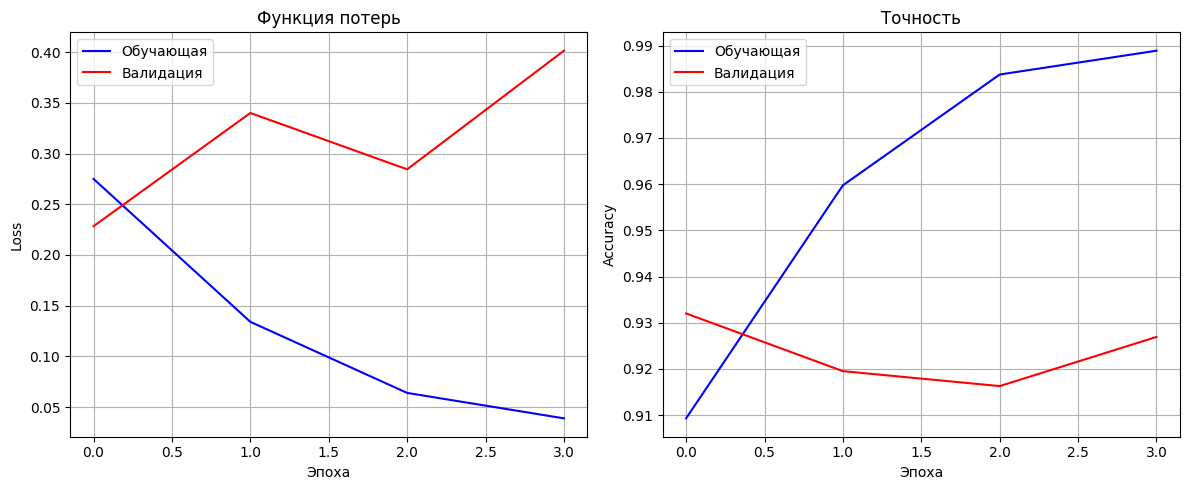


ОБУЧЕНИЕ ЗАВЕРШЕНО
Лучшая точность на валидации: 0.9320
Лучший F1-score: 0.9011
Лучший ROC-AUC: 0.9304



In [16]:
# Обучение модели
EPOCHS = 4
LEARNING_RATE = 3e-5

print("\n" + "="*50)
print("ИНИЦИАЛИЗАЦИЯ ПРОЦЕССА ОБУЧЕНИЯ")
print("="*50)
print(f"Всего эпох: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE:.0e}")
print(f"Устройство обучения: {device}\n")

# Расчет весов
print("Расчет весов для функции потерь:")
print(f"  Всего примеров: {len(train_df)}")
print(f"  Токсичных комментариев: {train_df['toxic'].sum()}")
print(f"  Коэффициент pos_weight: {len(train_df) / (2 * train_df['toxic'].sum()):.2f}\n")

# Инициализация модели
pos_weight = torch.tensor([len(train_df) / (2 * train_df['toxic'].sum())]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

history = {'train': [], 'val': []}

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Сначала выводим информацию о модели (только для первой эпохи)
    if epoch == 0:
        print("\nПервый прямой проход через модель:")
        print("-"*50)
        print(f"Размер входных данных: torch.Size([{BATCH_SIZE}, {MAX_LENGTH}])")
        print(f"Тип устройства: {device}")
        print("-"*50)
        print("Детали обработки:")
    
    # Затем создаем прогресс-бар для эпохи
    with tqdm(total=len(train_loader), 
              desc=f"Эпоха {epoch+1}/{EPOCHS}", 
              bar_format="{l_bar}{bar:20}{r_bar}",
              initial=0, 
              postfix={'loss': '0.0000', 'acc': '0.0000'}) as epoch_pbar:
        
        # Обучение с обновлением прогресс-бара
        train_loss, train_acc, train_f1, train_roc, train_pr = train_epoch(
            model, train_loader, loss_fn, optimizer, device, epoch_pbar
        )
    
    # Закрываем прогресс-бар эпохи
    epoch_pbar.close()
    
    # Валидация
    val_loss, val_acc, val_f1, val_roc, val_pr = eval_model(
        model, val_loader, loss_fn, device
    )
    
    # Сохранение результатов
    history['train'].append({
        'loss': train_loss,
        'accuracy': train_acc,
        'f1': train_f1,
        'roc_auc': train_roc,
        'pr_auc': train_pr
    })
    history['val'].append({
        'loss': val_loss,
        'accuracy': val_acc,
        'f1': val_f1,
        'roc_auc': val_roc,
        'pr_auc': val_pr
    })
    
    # Вывод метрик
    print(f"\nРезультаты эпохи {epoch + 1}:")
    print("-"*50)
    print(f"{'Метрика':<10} {'Обучающая':>12} {'Валидация':>12}")
    print("-"*50)
    print(f"{'Loss':<10} {train_loss:>12.4f} {val_loss:>12.4f}")
    print(f"{'Accuracy':<10} {train_acc:>12.4f} {val_acc:>12.4f}")
    print(f"{'F1':<10} {train_f1:>12.4f} {val_f1:>12.4f}")
    print(f"{'ROC-AUC':<10} {train_roc:>12.4f} {val_roc:>12.4f}")
    print(f"{'PR-AUC':<10} {train_pr:>12.4f} {val_pr:>12.4f}")
    print(f"Время выполнения: {time.time() - start_time:.2f} секунд")
    print(" ")

# Визуализация
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot([x['loss'] for x in history['train']], 'b-', label='Обучающая')
    plt.plot([x['loss'] for x in history['val']], 'r-', label='Валидация')
    plt.title('Функция потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot([x['accuracy'] for x in history['train']], 'b-', label='Обучающая')
    plt.plot([x['accuracy'] for x in history['val']], 'r-', label='Валидация')
    plt.title('Точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

print("\nВизуализация результатов обучения:")
plot_training_history(history)

# Итоги
print("\n" + "="*50)
print("ОБУЧЕНИЕ ЗАВЕРШЕНО")
print("="*50)
print(f"Лучшая точность на валидации: {max([x['accuracy'] for x in history['val']]):.4f}")
print(f"Лучший F1-score: {max([x['f1'] for x in history['val']]):.4f}")
print(f"Лучший ROC-AUC: {max([x['roc_auc'] for x in history['val']]):.4f}")
print("="*50 + "\n")

Оценка на тестовом наборе

In [17]:
test_loss, test_acc, test_f1, test_roc, test_pr = eval_model(
    model, test_loader, loss_fn, device
)
print(f'Test results:')
print(f'Loss: {test_loss:.4f}')
print(f'Accuracy: {test_acc:.4f}')
print(f'F1 Score: {test_f1:.4f}')
print(f'ROC-AUC: {test_roc:.4f}')
print(f'PR-AUC: {test_pr:.4f}')

Evaluating: 100%|██████████| 136/136 [00:20<00:00,  6.70it/s]

Test results:
Loss: 0.4665
Accuracy: 0.9177
F1 Score: 0.8759
ROC-AUC: 0.9052
PR-AUC: 0.8116


Сохранение модели

In [18]:
torch.save(model.state_dict(), 'bert_toxic_classifier.pth')